Import libraries

In [644]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import math
import numpy as np
from xgboost import plot_importance
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.model_selection import cross_val_score, KFold

Import files

In [645]:
characters = pd.read_csv("../Clean data/clean_character_data.csv")
movies = pd.read_csv("../Clean data/clean_movie_data.csv")
inputs = pd.read_csv("../Clean data/inputs.csv")

column_names = list(inputs.columns)
print(column_names)

['Wiki ID', 'Freebase ID_x', 'Movie name', 'Release date_x', 'Revenue', 'Runtime', 'IMDb rating', 'Wins', 'Nominations', 'Release year_x', 'Languages', 'Genres', 'Countries', 'English Language-onehot', 'Tamil Language-onehot', 'Hindi Language-onehot', 'Malayalam Language-onehot', 'German Language-onehot', 'Japanese Language-onehot', 'Korean Language-onehot', 'Spanish Language-onehot', 'Italian Language-onehot', 'French Language-onehot', 'Standard Mandarin-onehot', 'Standard Cantonese-onehot', 'Bengali Language-onehot', 'Cantonese-onehot', 'Telugu language-onehot', 'Russian Language-onehot', 'Portuguese Language-onehot', 'Urdu Language-onehot', 'Arabic Language-onehot', 'Tagalog language-onehot', 'Swedish Language-onehot', 'United States of America-onehot', 'United Kingdom-onehot', 'India-onehot', 'Canada-onehot', 'Germany-onehot', 'Japan-onehot', 'South Korea-onehot', 'Argentina-onehot', 'France-onehot', 'United Kingodm-onehot', 'Spain-onehot', 'Ireland-onehot', 'Hong Kong-onehot', 'Ch

Quick look at inputs

In [646]:
inputs.head()

,Wiki ID,Freebase ID_x,Movie name,Release date_x,Revenue,Runtime,IMDb rating,Wins,Nominations,Release year_x,...,Actor birth year_y,F-onehot_y,M-onehot_y,White_y,Black/African American_y,South Asian_y,East Asian_y,American Indian/Alaska Native_y,Pacific Islander_y,Other_y
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,2.315268e+07,98.0,4.9,NaN,2.0,2001,...,1969.0,0.0,1.0,0,1,0,0,0,0,0
1,6631279,/m/0gffwj,Little city,1997-04-04,NaN,93.0,5.8,NaN,NaN,1997,...,1964.0,1.0,0.0,0,0,0,0,0,0,1
2,171005,/m/016ywb,Henry V,1989-11-08,2.398142e+07,137.0,7.5,12.0,13.0,1989,...,1959.0,1.0,0.0,1,0,0,0,0,0,0
3,77856,/m/0kcn7,Mary Poppins,1964-08-27,9.655040e+08,139.0,7.8,22.0,17.0,1964,...,1917.0,0.0,1.0,0,0,0,0,0,0,1
4,156558,/m/014k4y,Baby Boy,2001-06-27,4.855272e+07,123.0,6.4,1.0,14.0,2001,...,1970.0,1.0,0.0,0,1,0,0,0,0,0


In [647]:
inputs.shape

(10918, 126)

In [648]:
# Assuming 'Revenues' is the column in your DataFrame 'df'
max_revenue = inputs['Revenue'].max()
min_revenue = inputs['Revenue'].min()

print("Maximum Revenue:", max_revenue)
print("Minimum Revenue:", min_revenue)


Maximum Revenue: 9522959437.465649
Minimum Revenue: 336.5110586513585


In [649]:
# DataFrame with revenues higher than 1,000,000,000
high_revenue_df = inputs[inputs['Revenue'] > 1000000000]

# DataFrame with revenues lower than 1,000
low_revenue_df = inputs[inputs['Revenue'] < 1000000]

In [650]:
high_revenue_df.shape

(99, 126)

In [651]:
low_revenue_df.shape

(952, 126)

All inputs analysis

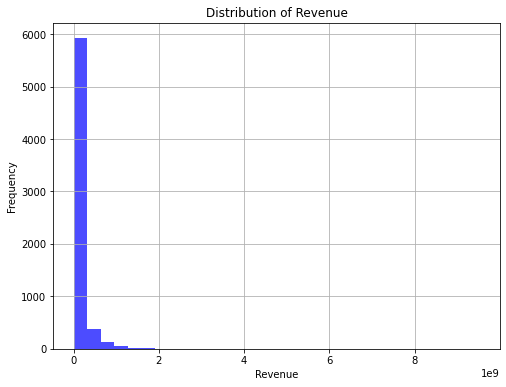

In [652]:
import matplotlib.pyplot as plt

# Assuming 'Revenues' is a column in your DataFrame 'df'
revenues = inputs['Revenue']

plt.figure(figsize=(8, 6))
plt.hist(revenues, bins=30, alpha=0.7, color='blue')  # Adjust the number of bins as needed
plt.title('Distribution of Revenue')
plt.xlabel('Revenue')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


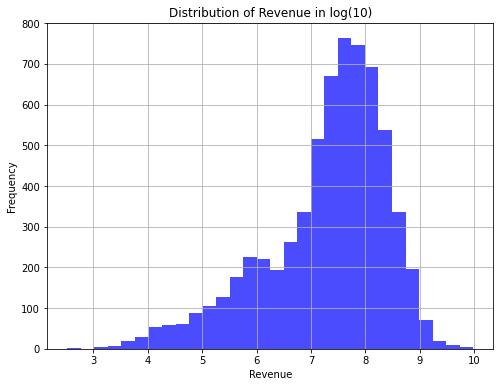

In [653]:
# Assuming 'Revenues' is a column in your DataFrame 'df'
revenues = inputs['Revenue']

plt.figure(figsize=(8, 6))
plt.hist(np.log10(inputs['Revenue']), bins=30, alpha=0.7, color='blue')  # Adjust the number of bins as needed
plt.title('Distribution of Revenue in log(10)')
plt.xlabel('Revenue')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Tail-cut inputs analysis

In [654]:
min_revenue_threshold = 100000  # Set your minimum revenue threshold
max_revenue_threshold = 1000000000  # Set your maximum revenue threshold

filtered_revenues_inputs = inputs[(inputs['Revenue'] > min_revenue_threshold) & (inputs['Revenue'] < max_revenue_threshold)]

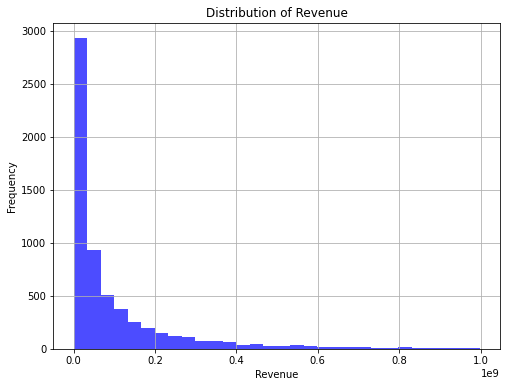

In [655]:
import matplotlib.pyplot as plt

# Assuming 'Revenues' is a column in your DataFrame 'df'
revenues = filtered_revenues_inputs['Revenue']

plt.figure(figsize=(8, 6))
plt.hist(revenues, bins=30, alpha=0.7, color='blue')  # Adjust the number of bins as needed
plt.title('Distribution of Revenue')
plt.xlabel('Revenue')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


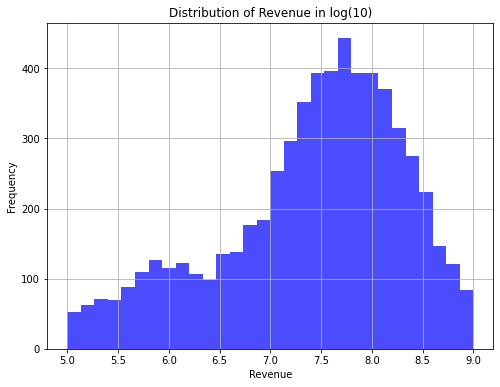

In [656]:
# Assuming 'Revenues' is a column in your DataFrame 'df'

plt.figure(figsize=(8, 6))
plt.hist(np.log10(filtered_revenues_inputs['Revenue']), bins=30, alpha=0.7, color='blue')  # Adjust the number of bins as needed
plt.title('Distribution of Revenue in log(10)')
plt.xlabel('Revenue')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Getting rid of unwanted columns for training

In [657]:
def feat_and_target(data):
    feature = data.drop('Revenue', axis = 1)
    target = np.log10(data['Revenue'])

    return feature, target

In [658]:
def data_splitting(feature, target):
    #Returns x_train, x_test, y_train, y_test
    return train_test_split(feature, target, test_size=0.2, random_state=42) 

In [659]:
#Fit le model
def XGB(xtrain, xtest, ytrain, ytest):
    # Tuned hyperparameters obtained from hyperopt
# Tuned hyperparameters obtained from hyperopt
    tuned_hyperparams = {
        'colsample_bytree': 0.5005769252894393,
        'eta': 0.13177477162226364,
        'gamma': 4.69425622236177,
        'max_depth': 10,
        'min_child_weight': 6,
        'reg_alpha': 102,
        'reg_lambda': 0.7632072468152908
}


# Create XGBoost regressor with tuned hyperparameters
    model = xgb.XGBRegressor(objective='reg:squarederror', **tuned_hyperparams)
    model.fit(xtrain, ytrain)
    plot_importance(model, max_num_features=30)

    #Des test pour voir si ça fonctionnes
    ypred = model.predict(xtest)
    mse = mean_squared_error(ytest, ypred)
    print("rmse",math.sqrt(mse))
    variance = ytest.std()
    print("Std", variance)
    errors = abs(ytest - ypred)
    mean_error = np.mean(errors)
    print("Mean Error:", mean_error)

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Creating a figure with two subplots side by side

    # First subplot (Histogram of ytrain)
    axes[0].hist(ypred, bins=30, alpha=0.7, color='blue')  # Adjust the number of bins as needed
    axes[0].set_title('Distribution of Revenue in log(10)')
    axes[0].set_xlabel('Revenue')
    axes[0].set_ylabel('Frequency')
    axes[0].grid(True)

    # Second subplot (Add your second plot here)
    axes[1].hist(ytest, bins=30, alpha=0.7, color='red')  # Replace x and y with your data for the second plot
    axes[1].set_title('Second Plot Title')
    axes[1].set_xlabel('X-axis label')
    axes[1].set_ylabel('Y-axis label')
    axes[1].grid(True)

    plt.tight_layout()  # Adjusts spacing between subplots for better appearance
    plt.show()

    

In [660]:
def pipeline(data):
    feature, target = feat_and_target(data)
    xtrain, xtest, ytrain, ytest = data_splitting(feature, target)
    XGB(xtrain, xtest, ytrain, ytest)

In [661]:
to_keep = ['Revenue', 'Runtime', 'Release year_x', 'English Language-onehot', 'Tamil Language-onehot', 'Hindi Language-onehot', 'Malayalam Language-onehot', 'German Language-onehot', 'Japanese Language-onehot', 'Korean Language-onehot', 'Spanish Language-onehot', 'Italian Language-onehot', 'French Language-onehot', 'Standard Mandarin-onehot', 'Standard Cantonese-onehot', 'Bengali Language-onehot', 'Cantonese-onehot', 'Telugu language-onehot', 'Russian Language-onehot', 'Portuguese Language-onehot', 'Urdu Language-onehot', 'Arabic Language-onehot', 'Tagalog language-onehot', 'Swedish Language-onehot', 'United States of America-onehot', 'United Kingdom-onehot', 'India-onehot', 'Canada-onehot', 'Germany-onehot', 'Japan-onehot', 'South Korea-onehot', 'Argentina-onehot', 'France-onehot', 'United Kingodm-onehot', 'Spain-onehot', 'Ireland-onehot', 'Hong Kong-onehot', 'China-onehot', 'Russia-onehot', 'Australia-onehot', 'Italy-onehot', 'Mexico-onehot', 'New Zealand-onehot', 'Brazil-onehot', 'Belgium-onehot', 'Denmark-onehot', 'Sweden-onehot', 'Netherlands-onehot', 'Philippines-onehot', 'Thriller-onehot', 'Science Fiction-onehot', 'Horror-onehot', 'Adventure-onehot', 'Action-onehot', 'Drama-onehot', 'Comedy-onehot', 'Romance Film-onehot', 'Musical-onehot', 'Fantasy-onehot', 'Family Film-onehot', 'Crime Fiction-onehot', 'Indie-onehot', 'World cinema-onehot', 'Mystery-onehot', 'Black-and-white-onehot', 'Crime Thriller-onehot', 'Actor height_x', 'Actor age at release_x', 'F-onehot_x', 'White_x', 'Black/African American_x', 'South Asian_x', 'East Asian_x', 'American Indian/Alaska Native_x', 'Pacific Islander_x', 'Other_x', 'Actor height_y', 'Actor age at release_y', 'F-onehot_y', 'White_y', 'Black/African American_y', 'South Asian_y', 'East Asian_y', 'American Indian/Alaska Native_y', 'Pacific Islander_y', 'Other_y']
#'IMDb rating', 'Wins', 'Nominations','M-onehot_x', 'M-onehot_y'

all_inputs = inputs[to_keep]

nan_counts = all_inputs.isna().sum()

with open("nan_info.txt", "w") as file:
    for column, count in nan_counts.items():
        file.write(f"Column '{column}' has {count} NaN values.\n")


inputs_filt = filtered_revenues_inputs[to_keep]
print("Number of features is: " + str(len(to_keep)))

all_inputs = all_inputs.dropna()
print(all_inputs.shape)
inputs_filt = inputs_filt.dropna()
print(inputs_filt.shape)


Number of features is: 86
(4843, 86)
(4589, 86)


In [662]:
inputs_interest = inputs[['Runtime', 'IMDb rating', 'Release year_x',
                'Adventure-onehot', 'Drama-onehot', 'Indie-onehot',
                'Actor age at release_x', 'Actor age at release_y', 'Revenue']]


nan_counts = inputs_interest.isna().sum()

for column, count in nan_counts.items():
    print(f"Column '{column}' has {count} NaN values.")

inputs_interest = inputs_interest.dropna()
print(inputs_interest.shape)

Column 'Runtime' has 622 NaN values.
Column 'IMDb rating' has 750 NaN values.
Column 'Release year_x' has 0 NaN values.
Column 'Adventure-onehot' has 0 NaN values.
Column 'Drama-onehot' has 0 NaN values.
Column 'Indie-onehot' has 0 NaN values.
Column 'Actor age at release_x' has 619 NaN values.
Column 'Actor age at release_y' has 867 NaN values.
Column 'Revenue' has 4385 NaN values.
(5875, 9)


rmse 0.9055709263992934
Std 1.079044781701139
Mean Error: 0.6838758607090939


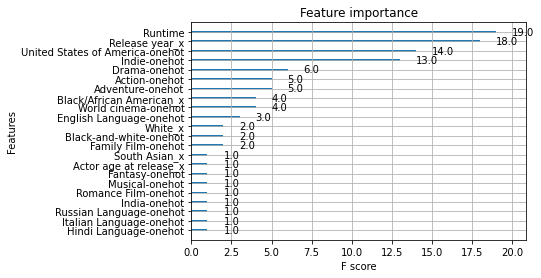

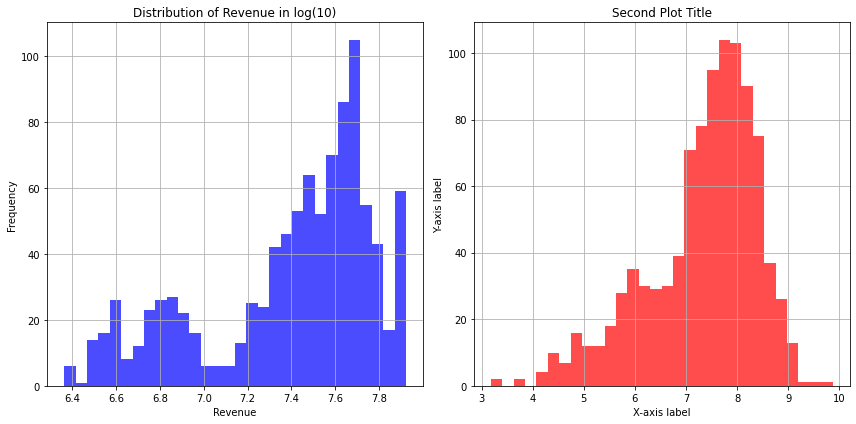

In [664]:
pipeline(all_inputs)

In [615]:
space={ 'eta': hp.uniform('eta', 0.01, 0.2),
        'max_depth': hp.quniform("max_depth", 3, 10, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

In [616]:
feature, target = feat_and_target(all_inputs)
xtrain, xtest, ytrain, ytest = data_splitting(feature, target)

def objective(space):
    # Define XGBoost regressor with hyperparameters from 'space'
    clf = xgb.XGBRegressor(
        eta = int(space['eta']),
        n_estimators=int(space['n_estimators']),
        max_depth=int(space['max_depth']),
        gamma=space['gamma'],
        reg_alpha=space['reg_alpha'],
        min_child_weight=space['min_child_weight'],
        colsample_bytree=space['colsample_bytree']
    )
    
    # Perform 5-fold cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    mse_scores = cross_val_score(clf, xtrain, ytrain, cv=kf, scoring='neg_mean_squared_error')
    
    # Calculate mean MSE from cross-validation scores
    mean_mse = np.mean(-mse_scores)
    
    # Return result to Hyperopt
    return {'loss': mean_mse, 'status': STATUS_OK}

In [617]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 200,
                        trials = trials)

100%|██████████| 200/200 [08:43<00:00,  2.62s/trial, best loss: 1.0300104536633867e+17]


In [618]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.5005769252894393, 'eta': 0.13177477162226364, 'gamma': 4.69425622236177, 'max_depth': 10.0, 'min_child_weight': 6.0, 'reg_alpha': 102.0, 'reg_lambda': 0.7632072468152908}


In [403]:
'''
from sklearn.feature_selection import RFE
from sklearn.svm import SVR  # For regression tasks; for classification, use SVC

# Assuming 'data' contains your features
# 'target' is your target variable
def which_feat(x,y):
    # Initialize an SVM regressor
    estimator = SVR(kernel='linear')

    # Initialize RFE with the estimator and number of features to select
    rfe = RFE(estimator, n_features_to_select=10)  # Specify the number of features to select

    # Fit RFE to your data
    rfe.fit(x, y)

    # Selected features mask
    selected_mask = rfe.support_

    # Apply the mask to get the selected features
    selected_features_rfe = x.columns[selected_mask]

    # Use the selected features for further modeling
    data_selected_rfe = x[selected_features_rfe]

    print(data_selected_rfe.columns)
'''

In [404]:
#which_feat(all_inputs_feat, all_inputs_target)

mse 379951837.23281854
Std 344624587.4210548


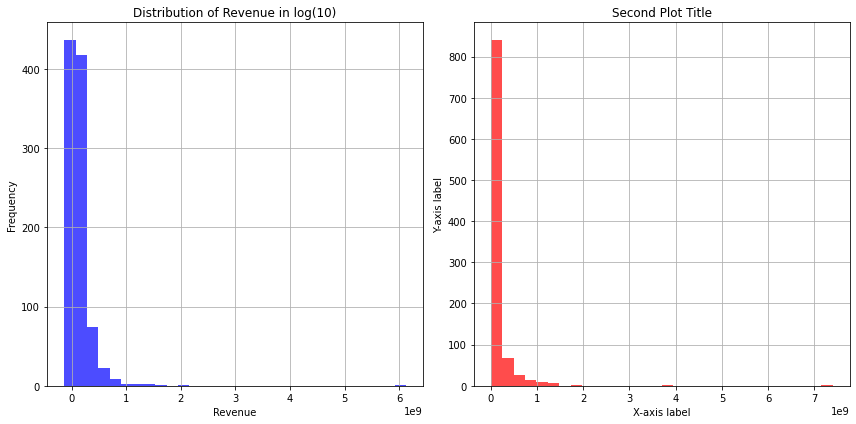

Mean Error: 133906545.26791629


In [423]:
XGB(xall_inputs_train, xall_inputs_test, yall_inputs_train, yall_inputs_test)

mse 150803167.0402343
Std 158039995.3901813


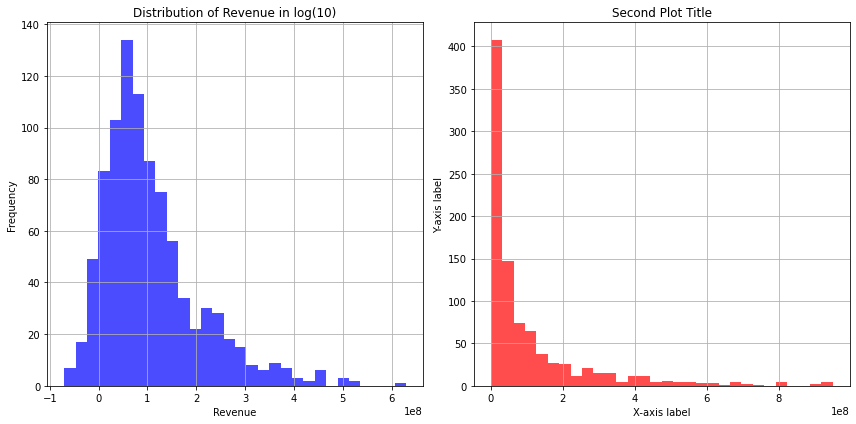

Mean Error: 97222527.55859202


In [424]:
XGB(xinputs_filt_train, xinputs_filt_test, yinputs_filt_train, yinputs_filt_test)

mse 318416373.57340014
Std 288028351.49950874


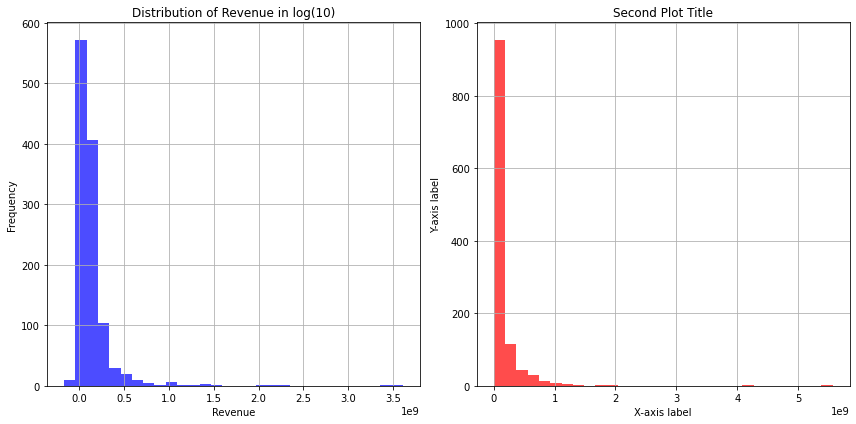

Mean Error: 143413696.01484597


In [425]:
XGB(xinputs_interest_train, xinputs_interest_test, yinputs_interest_train, yinputs_interest_test)

In [24]:
#Garder uniquement les features que l'on va utiliser 
# Peut être qu'on utilise ça 'IMDb rating', 'Wins', 'Nominations',
inputs_cleaned= inputs[['Revenue', 'Runtime',  'Release year_x', 'English Language-onehot', 'Tamil Language-onehot', 'Hindi Language-onehot', 'Malayalam Language-onehot', 'German Language-onehot', 'Japanese Language-onehot', 'Korean Language-onehot', 'Spanish Language-onehot', 'Italian Language-onehot', 'French Language-onehot', 'Standard Mandarin-onehot', 'Standard Cantonese-onehot', 'Bengali Language-onehot', 'Cantonese-onehot', 'Telugu language-onehot', 'Russian Language-onehot', 'Portuguese Language-onehot', 'Urdu Language-onehot', 'Arabic Language-onehot', 'Tagalog language-onehot', 'Swedish Language-onehot', 'United States of America-onehot', 'United Kingdom-onehot', 'India-onehot', 'Canada-onehot', 'Germany-onehot', 'Japan-onehot', 'South Korea-onehot', 'Argentina-onehot', 'France-onehot', 'United Kingodm-onehot', 'Spain-onehot', 'Ireland-onehot', 'Hong Kong-onehot', 'China-onehot', 'Russia-onehot', 'Australia-onehot', 'Italy-onehot', 'Mexico-onehot', 'New Zealand-onehot', 'Brazil-onehot', 'Belgium-onehot', 'Denmark-onehot', 'Sweden-onehot', 'Netherlands-onehot', 'Philippines-onehot', 'Thriller-onehot', 'Science Fiction-onehot', 'Horror-onehot', 'Adventure-onehot', 'Action-onehot', 'Drama-onehot', 'Comedy-onehot', 'Romance Film-onehot', 'Musical-onehot', 'Fantasy-onehot', 'Family Film-onehot', 'Crime Fiction-onehot', 'Indie-onehot', 'World cinema-onehot', 'Mystery-onehot', 'Black-and-white-onehot', 'Crime Thriller-onehot', 'Actor height_x', 'Actor age at release_x', 'F-onehot_x', 'Actor height_y', 'Actor age at release_y', 'F-onehot_y']]
inputs_cleaned = inputs_cleaned.dropna()
#Mettre les revenus en logarithmique mais pas sur qu'on fasse ça
#inputs_cleaned["Revenue"] = np.log10(inputs['Revenue'])
inputs_cleaned["Revenue"]

0        2.315268e+07
2        2.398142e+07
5        4.855272e+07
10       2.497657e+05
11       9.346851e+06
             ...     
18263    1.097915e+06
18266    9.223044e+08
18267    1.916860e+08
18276    7.143263e+08
18281    1.180217e+07
Name: Revenue, Length: 4844, dtype: float64

In [6]:
#TEST pour voir si diminuer le nombre des features change quelque chose
#inputs_cleaned = inputs_cleaned[["Revenue",'Runtime','Release year','Primary Actor age at release']]

In [7]:
# On mets les features dans X et les Revenus dans Y
X = inputs_cleaned.drop('Revenue', axis=1)  # Features
y = inputs_cleaned['Revenue']  # Target variable

#Splitting du data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Fit le model
model = xgb.XGBRegressor(objective='reg:squarederror')
model.fit(X_train, y_train)

#Des test pour voir si ça fonctionnes
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("mse",math.sqrt(mse))
variance = y_test.std()
print("Std", variance)

mse 0.903306965071381
Std 1.0771125732448288


In [8]:
for element in y_pred:
    print(element)

8.313767
8.451599
5.6029754
7.656711
7.2957606
6.435615
7.7006574
5.3529553
7.454218
8.332987
6.7946033
8.232753
7.7827554
7.664387
7.8767705
8.747814
7.037436
6.2798686
7.4082527
8.164811
7.460501
7.351157
7.0652876
7.3756948
7.3150396
8.541087
5.8049045
7.035201
5.9461646
6.0859985
8.106104
8.090466
5.941218
7.7500634
7.211997
6.4064045
7.1879354
5.886017
7.9625397
8.132125
6.931157
7.553305
6.8548455
7.67286
7.0453296
6.788922
5.869265
7.602956
7.7726316
7.4879947
8.210527
7.8326573
7.3138227
8.20651
7.6694903
7.6754384
7.4023824
6.2893567
6.704009
8.202305
8.560422
8.105593
6.736525
6.9261794
8.418691
7.356221
7.6217494
7.394224
5.8614116
6.472465
5.2926106
8.559706
7.2910814
7.9217052
7.107577
7.7079644
7.998958
7.1027775
7.13786
7.5474334
8.689077
5.86803
5.994997
7.5907097
6.839483
7.1127973
5.768486
7.6518855
6.09361
6.996807
8.326481
7.2853394
7.030536
7.7137847
8.269083
6.383476
7.1523
8.313122
7.995298
7.722409
7.9038873
8.29811
7.7459793
6.5130167
5.7389507
7.235896
6.06279

In [9]:
for element in y_test:
    print(element)

max_value = np.max(y_test)
min_value = np.min(y_test)

print("Highest value in test:", max_value)
print("Lowest value:", min_value)

max_value = np.max(y_pred)
min_value = np.min(y_pred)

print("Highest value in pred:", max_value)
print("Lowest value:", min_value)

8.070054085893497
8.556225884315584
3.8451974170391394
4.67067591744719
8.226853900101124
7.3842248674425
6.817531191294152
5.412740177666531
8.036429598515161
7.7780393287685765
6.039465542282045
8.56410017333038
7.705025192588659
7.990447169200559
7.513332461870222
8.650270134650468
5.396751957682388
6.61173062864997
7.172116383985829
7.388786186527921
7.999317989704248
7.422407425894733
7.208395272525201
7.548258964920269
6.631483216881376
8.457792356037661
6.796209848882615
4.660787756118825
5.793583037312236
5.7658773807478
7.513904346597522
8.277106436354622
5.809923440833111
8.714433583818295
6.575117145638445
5.944658889145672
7.623693833599677
7.849117562658597
7.697712574000788
8.389223136347374
7.982411709191872
8.824018175079653
6.6555587234735505
7.973174916645417
8.323606290529733
6.141447863236223
5.0161250419438135
8.286909335300905
7.614224645673506
5.7879483266589276
8.931310462436304
8.5347030108158
7.3128569606550275
8.112362387297978
7.247640803790404
8.14656311886